In [1]:
import pandas as pd

import config

In [2]:
from framework.data.data_loader import DataLoader

df = None

data_loader = DataLoader()
df = data_loader.load_data_from_disk(symbol=config.SYMBOL, timeframe=config.TIMEFRAME, suffix="_raw")

if df is not None:
    print(f"Data Rows: {len(df)}, Columns: {', '.join(df.columns)}")

  [WARN] File not found: framework/data/BTC_USDT_5m_raw.csv


In [3]:
from framework.analysis.technical_indicators import TechnicalIndicators

technical_indicators = TechnicalIndicators()

if df is None:
    df = data_loader.fetch_historical_data(symbol=config.SYMBOL, timeframe=config.TIMEFRAME, days=365)

    df = technical_indicators.add_indicators(df)

    data_loader.save_to_csv(df, symbol=config.SYMBOL, timeframe=config.TIMEFRAME, suffix="_raw")

    print(f"Data Rows: {len(df)}, Columns: {', '.join(df.columns)}")

Fetching BTC/USDT (5m) from 2025-02-24...
  > Downloaded to: 2025-02-28 02:50:00
  > Downloaded to: 2025-03-03 14:10:00
  > Downloaded to: 2025-03-07 01:30:00
  > Downloaded to: 2025-03-10 12:50:00
  > Downloaded to: 2025-03-14 00:10:00
  > Downloaded to: 2025-03-17 11:30:00
  > Downloaded to: 2025-03-20 22:50:00
  > Downloaded to: 2025-03-24 10:10:00
  > Downloaded to: 2025-03-27 21:30:00
  > Downloaded to: 2025-03-31 09:50:00
  > Downloaded to: 2025-04-03 21:10:00
  > Downloaded to: 2025-04-07 08:30:00
  > Downloaded to: 2025-04-10 19:50:00
  > Downloaded to: 2025-04-14 07:10:00
  > Downloaded to: 2025-04-17 18:30:00
  > Downloaded to: 2025-04-21 05:50:00
  > Downloaded to: 2025-04-24 17:10:00
  > Downloaded to: 2025-04-28 04:30:00
  > Downloaded to: 2025-05-01 15:50:00
  > Downloaded to: 2025-05-05 03:10:00
  > Downloaded to: 2025-05-08 14:30:00
  > Downloaded to: 2025-05-12 01:50:00
  > Downloaded to: 2025-05-15 13:10:00
  > Downloaded to: 2025-05-19 00:30:00
  > Downloaded to: 202

In [4]:
from sklearn.model_selection import train_test_split

# First split: 70% Train, 30% Temp (Val + Test)
train_df, temp_df = train_test_split(df, test_size=0.3, shuffle=False)

# Second split: Split the 30% Temp into 50% Val (15% total) and 50% Test (15% total)
val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=False)

# Reset indices to ensure environment works correctly
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [5]:
from framework.analysis.technical_indicators import TechnicalIndicators

technical_indicators.fit_scalers(train_df)

train_df = technical_indicators.normalize(train_df)
val_df = technical_indicators.normalize(val_df)
test_df = technical_indicators.normalize(test_df)

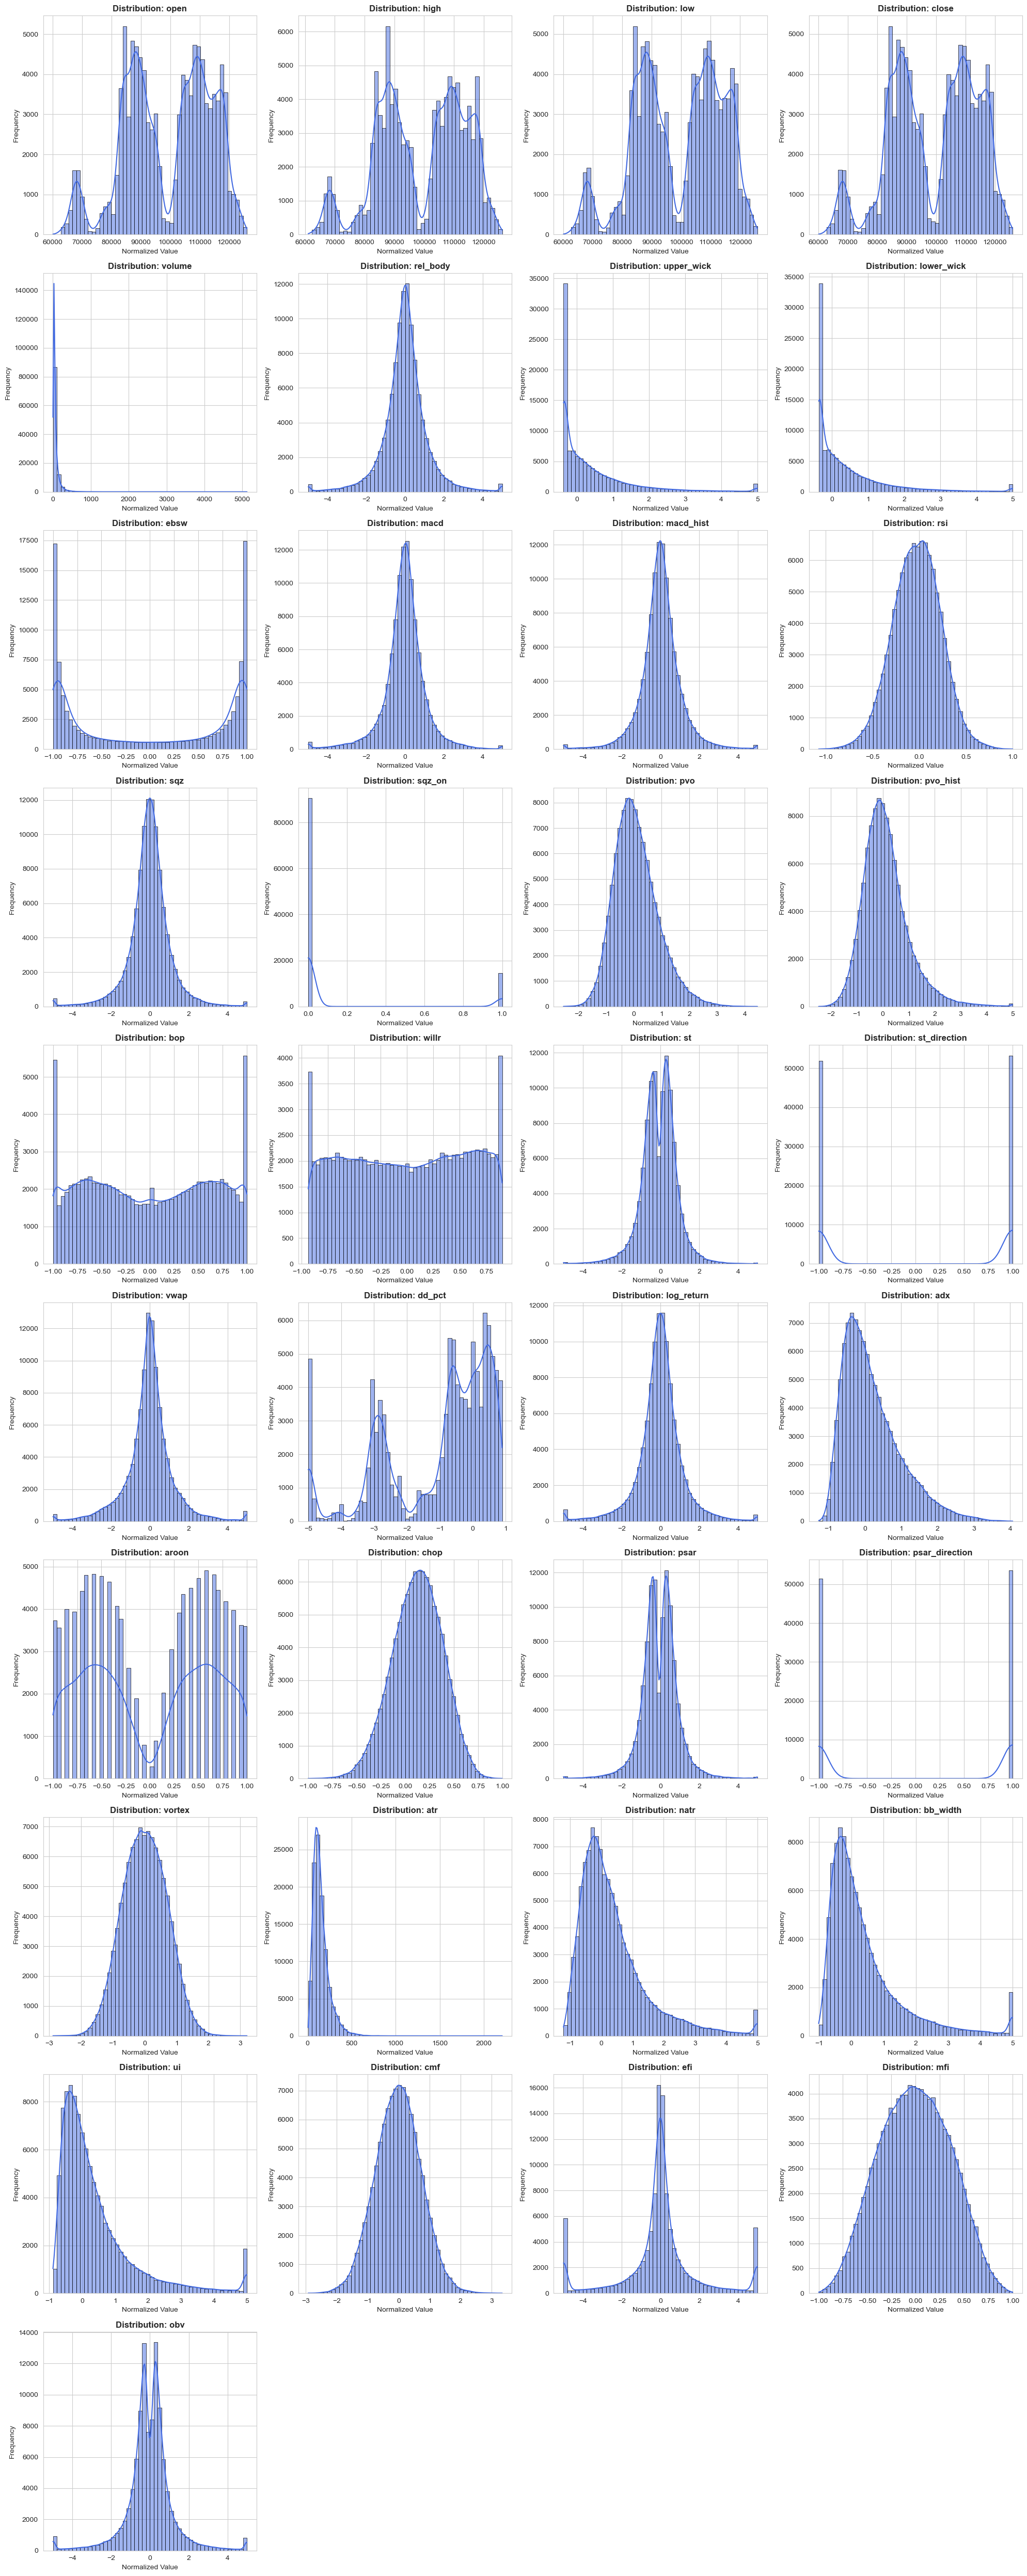

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

plot_df = pd.concat([train_df, val_df, test_df], axis=0)

# Use 4 columns for a balanced 8x4 Grid
cols = 4
rows = math.ceil(len(plot_df.columns) / cols)

plt.figure(figsize=(20, 5 * rows))  # Adjust figsize for clarity
sns.set_style("whitegrid")

for i, column in enumerate(plot_df.columns):
    plt.subplot(rows, cols, i + 1)

    # Plot histogram with KDE
    sns.histplot(plot_df[column], kde=True, bins=50, color="royalblue", edgecolor="black", linewidth=0.5)

    plt.title(f"Distribution: {column}", fontsize=12, fontweight="bold")
    plt.xlabel("Normalized Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [9]:
features = [col for col in train_df.columns if col not in ["open", "high", "low", "close", "volume", "atr"]]

len(features), features

(31,
 ['rel_body',
  'upper_wick',
  'lower_wick',
  'ebsw',
  'macd',
  'macd_hist',
  'rsi',
  'sqz',
  'sqz_on',
  'pvo',
  'pvo_hist',
  'bop',
  'willr',
  'st',
  'st_direction',
  'vwap',
  'dd_pct',
  'log_return',
  'adx',
  'aroon',
  'chop',
  'psar',
  'psar_direction',
  'vortex',
  'natr',
  'bb_width',
  'ui',
  'cmf',
  'efi',
  'mfi',
  'obv'])

Saved correlation matrix: (31, 31)


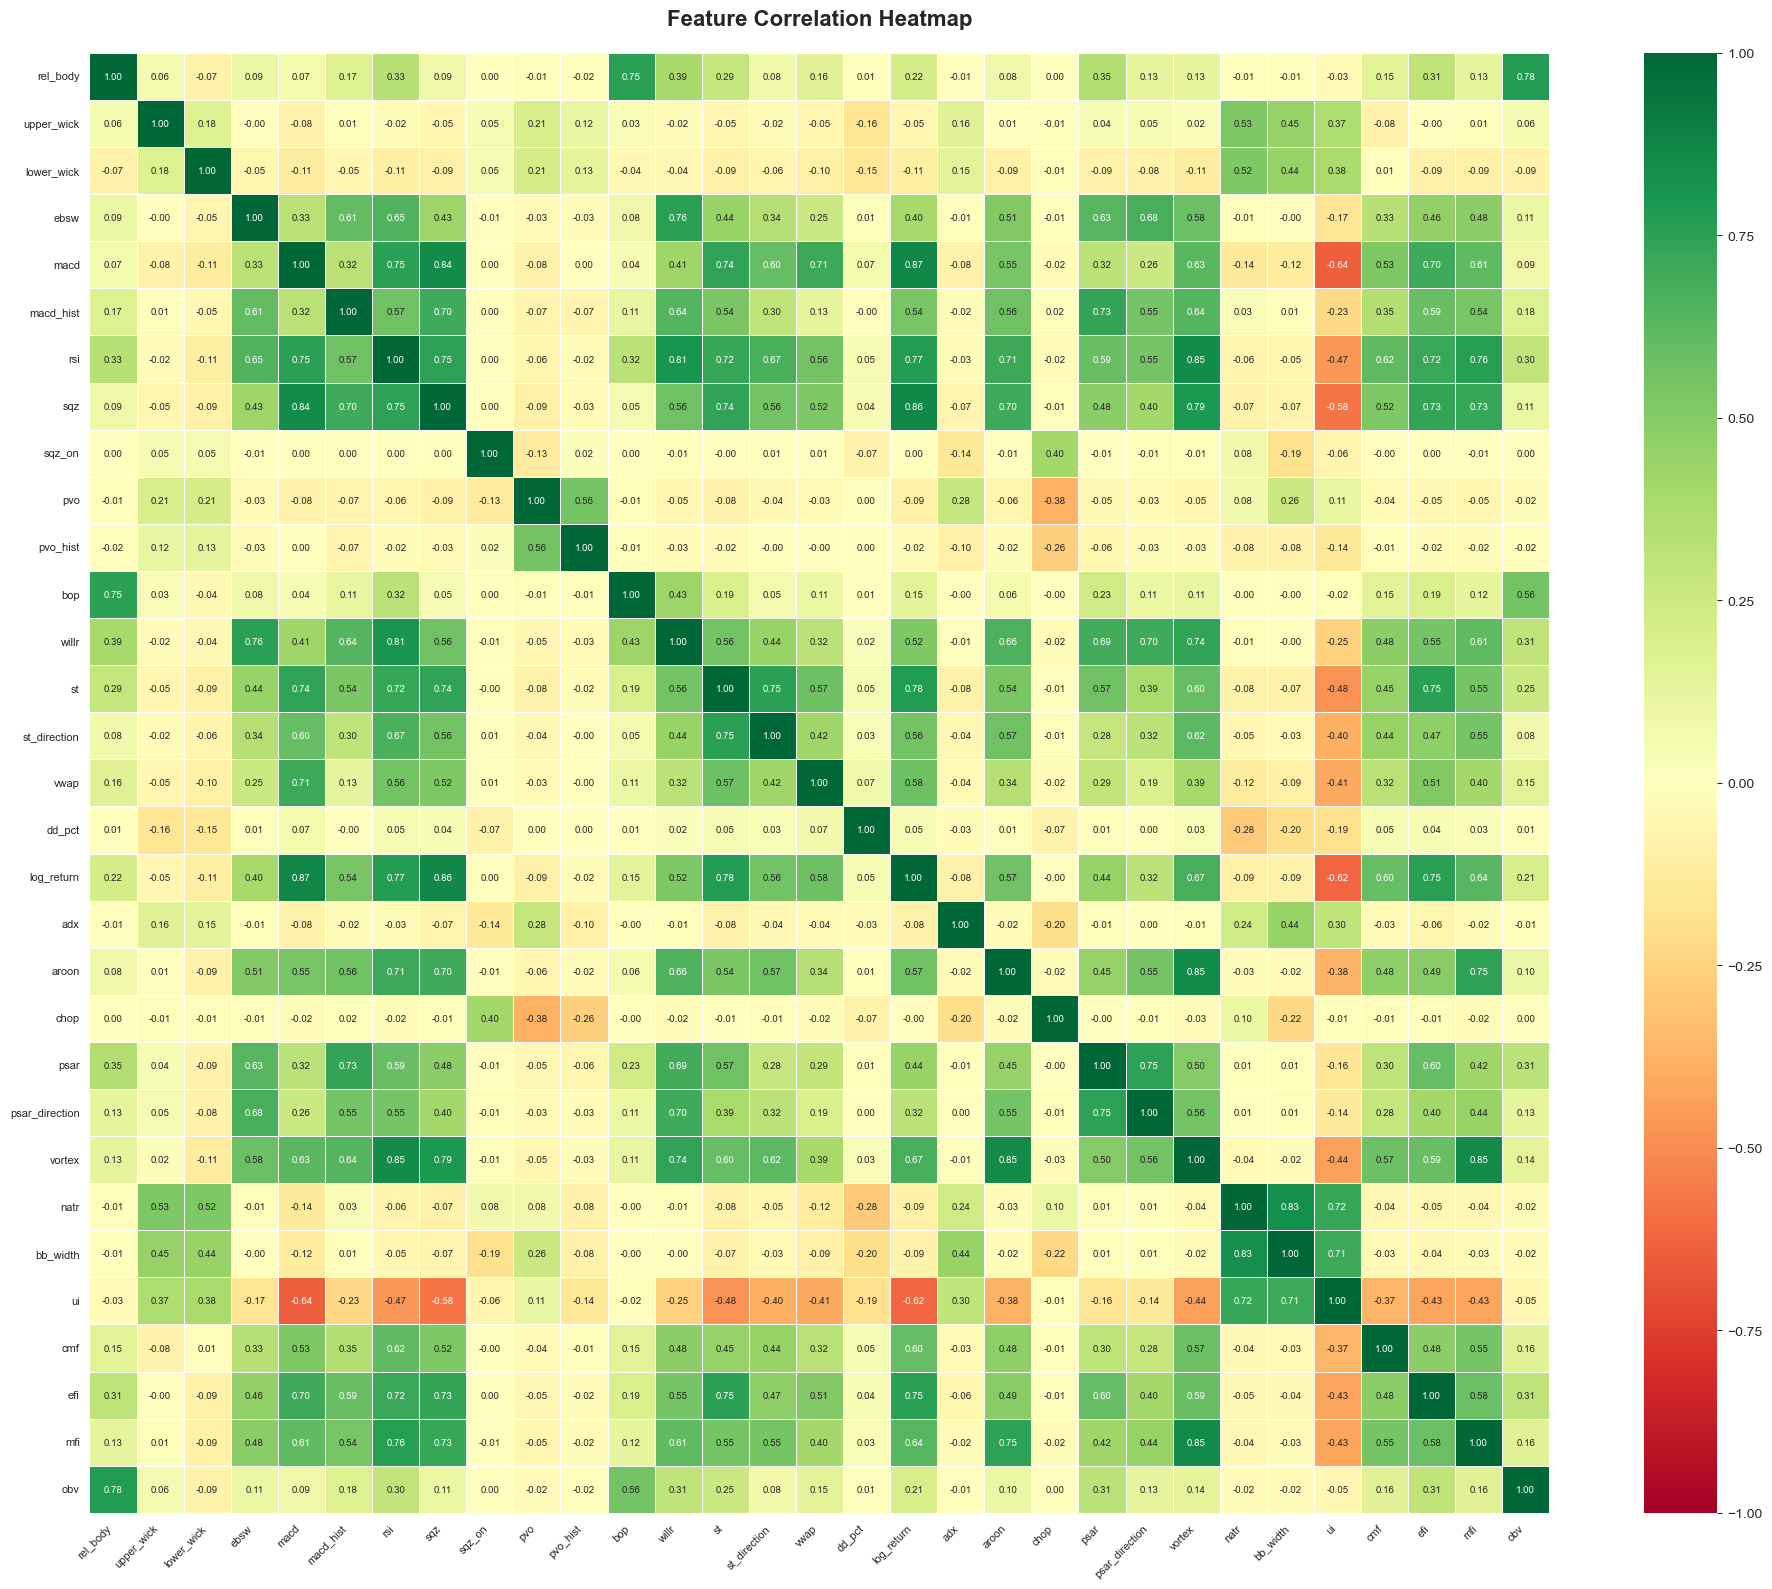

Found 3 highly correlated pairs (|corr| > 0.85):


,Feature A,Feature B,Correlation
0,macd,log_return,0.872985
1,sqz,log_return,0.859751
4,vortex,mfi,0.852459


In [8]:
# Compute correlation matrix on feature columns only
corr_matrix = plot_df[features].corr(method="pearson")

# Save to CSV
corr_matrix.to_csv("framework/analysis/pearson_correlation.csv")
print(f"Saved correlation matrix: {corr_matrix.shape}")

fig, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(
    corr_matrix,
    ax=ax,
    annot=True,           # Show numbers in each cell
    fmt=".2f",            # 2 decimal places
    cmap="RdYlGn",        # Red = negative, Yellow = neutral, Green = positive
    center=0,             # Anchor color scale at 0
    vmin=-1, vmax=1,
    linewidths=0.5,
    annot_kws={"size": 7},
    square=True,
)
ax.set_title("Feature Correlation Heatmap", fontsize=16, fontweight="bold", pad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

# Extract pairs with |correlation| > threshold (excluding self-correlation)
THRESHOLD = 0.85

high_corr_pairs = (
    corr_matrix
    .where(lambda df: (df.abs() > THRESHOLD) & (df != 1.0))
    .stack()
    .reset_index()
    .rename(columns={"level_0": "Feature A", "level_1": "Feature B", 0: "Correlation"})
    .drop_duplicates(subset=["Correlation"])   # Remove duplicates (A-B and B-A)
    .sort_values("Correlation", key=abs, ascending=False)
)

print(f"Found {len(high_corr_pairs)} highly correlated pairs (|corr| > {THRESHOLD}):")
high_corr_pairs

In [ ]:
from framework.ai.training.train_agent import train

train(train_df, features)

Training on 31 Features: ['rel_body', 'upper_wick', 'lower_wick', 'ebsw', 'macd', 'macd_hist', 'rsi', 'sqz', 'sqz_on', 'pvo', 'pvo_hist', 'bop', 'willr', 'st', 'st_direction', 'vwap', 'dd_pct', 'log_return', 'adx', 'aroon', 'chop', 'psar', 'psar_direction', 'vortex', 'natr', 'bb_width', 'ui', 'cmf', 'efi', 'mfi', 'obv']
Initializing PPO Agent...
Using cpu device
Training for 1000000 steps...
Logging to framework/ai/logs\PPO_4
---------------------------------
| custom/            |          |
|    balance         | 961      |
|    net_worth       | 961      |
|    reward          | -0.0001  |
|    trade_pnl       | 0        |
| time/              |          |
|    fps             | 85       |
|    iterations      | 1        |
|    time_elapsed    | 23       |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| custom/                 |              |
|    balance              | 925          |
|    net_worth            | 925  

In [ ]:
from framework.ai.training.train_agent import evaluate

evaluate(val_df, features, "Validation")

In [ ]:
evaluate(test_df, features, "Test")